# Transformer 실습
과제: imdb 데이터셋의 마지막 토큰 예측

##[Feedback]
아랫부분에서 Colab에서 매번마다 돌려야 아래 from datasets import load_dataset 작동이 되는데, notebook에서 pip install 않돌리고 진행방법 있을가요?

In [1]:
#이부분 Colab에서 매번마다 돌려야 아래 from datasets import load_dataset 작동이 되는데, notebook에서 않돌리고 진행방법 있을가요?
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
import pandas as pd
from torch.nn.utils.rnn import pad_sequence

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


In [3]:
max_len = 400
batch_size=64
d_model=32
n_layers=2
dff = 32

device = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
ds = load_dataset("stanfordnlp/imdb")  # 영화 리뷰 감정분류 데이터셋 가져옵니다.
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased') # huggingface 의 tokenizer 단어 분석기 로딩

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
print("----------------")
print(ds['train'][0]) # imdb 첫째 데이터셋을 보기
print("----------------")
for i in range(5):    # imdb 데이터셋 몇개 훌터보기
    print(ds['train'][i])
print("----------------")
print(ds['train'][0]) # imdb 첫째 데이터셋을 보기
for i in range(5):    # imdb label
    print(ds['train'][i]['label'])
print("----------------")
print("text len:",len(ds['train']['text']))
print("label len:",len(ds['train']['label']))
print("----------------")
lab_counts_0 = 0
lab_counts_1 = 0
for i in range(len(ds['train']['label'])):    # imdb label
    if ds['train'][i]['label']==0: lab_counts_0 += 1
    else:lab_counts_1 += 1
print("lab_counts_0:",lab_counts_0)
print("lab_counts_1:",lab_counts_1)

----------------
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes a

In [6]:
df = pd.DataFrame(ds['train'][:])  # Pandas DataFrame
print(df.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [7]:
# collate_fn: 사용자 정의 함수로, 데이터 배치를 처리하는 방식을 정의합니다. 예를 들어, 시퀀스 데이터의 길이를 맞추기 위해 패딩(padding)을 추가하거나, 특정 데이터 형식으로 변환하는 역할을 합니다.
def collate_fn(batch):
  texts, labels = [], []
  for row in batch:
    #texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids) #단어를 tokenizer 분석처리,  Tensor 로 전환한다.
    #labels = torch.LongTensor(labels) # Label 를 Tensor로 전환한다.  0 부정평가  1 긍정평가  -> 이번 기본과제에서 skip
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])  # 과제의 필요로 2진 예측으로 부터 단어 예측으로 전환, 마지막으로 2번째 text (마지막 토큰은 end 부호니깐 넘어가서 -2로 선택합니다.)
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))  # 마지막으로 2번째 text (입력값 x)

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)  # pad_sequence: 매번 text의 길이를 400으로 정하고 기타 길이에 못미치는건 pad_token_id로 채웁니다.  길이에 초과되는 부분은 cutting 처리
  labels = torch.LongTensor(labels)

  return texts, labels


# batch_size: 한 번에 모델에 입력되는 데이터 묶음의 크기를 64로 설정합니다. 즉, 훈련 시 한 번의 반복(iteration)에서 처리되는 데이터 개수가 64개입니다.
# shuffle:  데이터를 매 epoch(훈련 반복 주기)마다 무작위로 섞습니다. 이를 통해 모델이 데이터 순서에 의한 학습 편향을 피할 수 있습니다.
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

print(train_loader)

##[My code] 과정해석
1. IMDB 데이터셋을 로드합니다.
2. Hugging Face의 사전 학습된 BERT 토크나이저를 사용하여 텍스트 데이터를 모델이 사용할 수 있는 입력 형식으로 변환합니다.
3. 데이터를 배치(batch) 단위로 정리하기 위한 커스텀 정리 함수(collate_fn)를 정의합니다.
4. PyTorch의 DataLoader를 사용하여 데이터셋을 반복 가능한 데이터 배치로 설정함.


## Self-attention

In [8]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):  #SelfAttention 에 대한 정의
    super().__init__()

    self.input_dim = input_dim   #입력 차원
    self.d_model = d_model       #출력 차원

    self.wq = nn.Linear(input_dim, d_model)   #Qurey
    self.wk = nn.Linear(input_dim, d_model)   #Key
    self.wv = nn.Linear(input_dim, d_model)   #Velue
    self.dense = nn.Linear(d_model, d_model)  # 최종결과를 추출할 Victer 변환

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    # (B, S, D) * (B, D, S) = (B, S, S)  전치 k， (B, S, d_model) 로 부터 (B, d_model, S) 변경합니다.
    # 즉 Qurey * 전치(key) = Score
    score = torch.matmul(q, k.transpose(-1, -2))
    score = score / sqrt(self.d_model)

    #마스크 행렬의 작용: 유효하지 않은 위치의 점수를 매우 작은 값(-1e9)으로 설정하여 softmax 이후 거의 0에 가까워지도록 합니다.
    #마스크 행렬의 형태는 보통 (B, S, S)이며, 점수 행렬과 동일한 차원을 가집
    #Q: 유효하지 않은지를 어떻게 확인하는지 아직 이해가 가지 않습니다.
    if mask is not None:
      score = score + (mask * -1e9)

    # Score 값을 정규화(归一化) 합니다.
    score = self.softmax(score)

    # Score * value 하여 SelfAttention 을 완성시킵니다.
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result  # SelfAttention matrix

##TransformerLayer

In [9]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim  #입력값
    self.d_model = d_model  #Self-Attention 후의 모델
    self.dff = dff #신경망(FFN)의 은닉층 , 모델의 표현 능력을 향상시키기 위해 사용됩니다.

    self.sa = SelfAttention(input_dim, d_model)  #Self-Attention 초기화
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),  #첫 번째 선형 변환으로, 특징 차원을 d_model에서 dff로 확대.
      nn.ReLU(),                #비선형 활성화 함수로, 네트워크에 비선형 특성을 추가.
      nn.Linear(dff, d_model)   #두 번째 선형 변환으로, 특징 차원을 dff에서 d_model로 축소.
    )


  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

## Positional encoding


In [10]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


##[Feedback]
Positional encoding 의 원리가 아직 이해가 되지 않아 일단 코딩을 그대로 가져쓰고 별도로 재 학습이 필요하겠습니다.

Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

##TextClassifier

In [11]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size   #text 단어수량
    self.d_model = d_model         #임베딩과 특성 표현의 차원
    self.n_layers = n_layers       #Transformer 층 수량
    self.dff = dff                 #피드포워드 신경망의 은닉층 차원

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)

    #여러 Transformer 레이어를 묶는 데 사용됩니다
    #각각의 레이어는 TransformerLayer로 구성되며
    #입력과 출력의 특성 차원은 d_model입니다.
    #전방 전달 신경망의 은닉층 차원은 dff입니다
    #n_layers는 Transformer 레이어의 수를 결정합니다.
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

    #완전 연결 계층으로, 분류 작업에 사용됩니다.
    #출력 계층을 1로 부터 사전 크기로 바꾸었습니다.
    self.classification = nn.Linear(d_model,self.vocab_size)

  #X의 형태는(B, S)  B:batch,  S:시퀀스 len
  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]  # 차원의 증가  (B, S) ->  (B, 1, S)
    seq_len = x.shape[1]

    x = self.embedding(x)   #입력 토큰 ID를 임베딩 벡터로 변환,  (B, S)에서 (B, S, d_model)로 변경
    x = x * sqrt(self.d_model)  # 임베딩 값이 지나치게 작아지는 것을 방지
    x = x + self.pos_encoding[:, :seq_len] # 상대위치를 설정함

    #다층의 Transformer  ,  출력형태: (B, S, d_model)
    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]  #전 행의 대표하는 첫째 토큰만 classifier에 넣습니다.
    x = self.classification(x)

    return x


#model = TextClassifier(len(tokenizer), 32, 2, 32)
model = TextClassifier(
        vocab_size=len(tokenizer),  # bert-base-uncased 의  30,522 개 단어의 토큰
        d_model=d_model,
        n_layers=n_layers,
        dff=dff
)
model = model.to(device)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

##모델구조 정보 출력

In [12]:
pip install torchinfo

In [13]:
from torchinfo import summary

# 모델 정보 출력
summary(model, input_size=(batch_size, max_len), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [64, 30522]               12,800
├─Embedding: 1-1                         [64, 400, 32]             976,704
├─ModuleList: 1-2                        --                        --
│    └─TransformerLayer: 2-1             [64, 400, 32]             --
│    │    └─SelfAttention: 3-1           [64, 400, 32]             4,224
│    │    └─Sequential: 3-2              [64, 400, 32]             2,112
│    └─TransformerLayer: 2-2             [64, 400, 32]             --
│    │    └─SelfAttention: 3-3           [64, 400, 32]             4,224
│    │    └─Sequential: 3-4              [64, 400, 32]             2,112
├─Linear: 1-3                            [64, 30522]               1,007,226
Total params: 2,009,402
Trainable params: 1,996,602
Non-trainable params: 12,800
Total mult-adds (M): 127.78
Input size (MB): 0.20
Forward/backward pass size (MB): 100.82
Params size (MB): 7.99
Est

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [14]:
from torch.optim import Adam

lr = 0.001
#loss_fn = nn.BCEWithLogitsLoss() # 이진 분류에 적합
loss_fn = nn.CrossEntropyLoss() # 다중 클래스 분류 적합
optimizer = Adam(model.parameters(), lr=lr)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).long()

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) # 다중클래스 적합
    # preds = (preds > 0).long()[..., 0] # 이진분류 적합

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [16]:
n_epochs = 50
train_accs = []
test_accs =[]
total_losses = []
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
      model.zero_grad()
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device).long()

      preds = model(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
      model.eval()
      train_acc = accuracy(model, train_loader)
      test_acc = accuracy(model, test_loader)
      print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
      train_accs.append(train_acc)
      test_accs.append(test_acc)
      total_losses.append(total_loss)



Epoch   0 | Train Loss: 1511.6830418109894
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   1 | Train Loss: 1179.1822556257248
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   2 | Train Loss: 1125.7819921970367
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   3 | Train Loss: 1107.362753033638
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   4 | Train Loss: 1081.9747548103333
=========> Train acc: 0.558 | Test acc: 0.563
Epoch   5 | Train Loss: 1071.1908828020096
=========> Train acc: 0.558 | Test acc: 0.563
Epoch   6 | Train Loss: 1065.069581747055
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   7 | Train Loss: 1056.4103846549988
=========> Train acc: 0.558 | Test acc: 0.563
Epoch   8 | Train Loss: 1054.7797603607178
=========> Train acc: 0.558 | Test acc: 0.563
Epoch   9 | Train Loss: 1049.0376821756363
=========> Train acc: 0.558 | Test acc: 0.561
Epoch  10 | Train Loss: 1046.5772395133972
=========> Train acc: 0.557 | Test acc: 0.563
Epoch  11 | Train Loss:

In [17]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

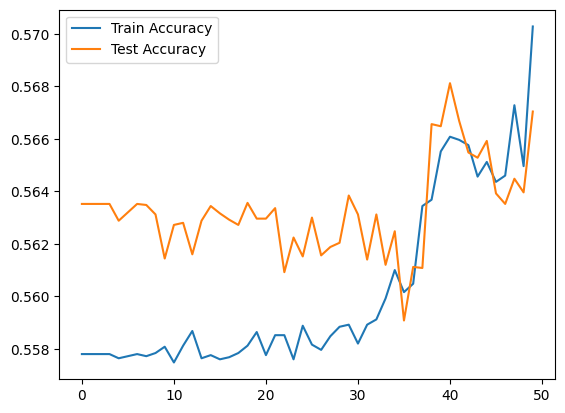

In [18]:
plot_acc(train_accs, test_accs, label1='Train Accuracy', label2='Test Accuracy')

##[Conclusion]
*   30차 배치까지 평온적으로 되다가 35차 부근에서 급속 성능이 나아지는것을 볼수가 있습니다.
*   총체로 예측 정확율이 55%~57% 사이인데, 성능이 처음부터 확실하게 나아지지가 않았습니다.
*   예측율이 비교적 낮은 원인은 혹시 마지막 텍스트가 점 부호라서 인지 아니면 예측 모델 자체의 문제인지가 아직 의문입니다.